## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

<br><br>

## Import the stock dataset from CSV file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/DATA.csv')
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,...,RUSSELL2000,HENG SENG,SSE,Crude Oil,Gold,VIX,USD index,Amazon,Google,Microsoft
0,7/2/2010,8.946072,8.961785,8.685715,8.819285,693842800,2091.790039,6434.810059,1022.580017,4838.09,...,598.969971,19905.32031,2382.900879,72.139999,1207.400024,30.120001,84.43,109.139999,109.139999,23.270000
1,7/1/2010,9.082143,9.100000,8.686429,8.874286,1022896000,2101.360107,6462.029785,1027.369995,4805.75,...,604.760010,NaN,2373.791992,72.949997,1206.300049,32.860001,84.72,110.959999,110.959999,23.160000
2,7/6/2010,8.964286,9.028571,8.791429,8.879642,615235600,2093.879883,6486.089844,1028.060059,4965.00,...,590.030029,20084.11914,2409.424072,71.980003,1194.800049,29.650000,84.08,110.059998,110.059998,23.820000
3,7/7/2010,8.946072,9.241786,8.919642,9.238214,654556000,2159.469971,6685.779785,1060.270020,5014.82,...,611.659973,19857.07031,2421.116943,74.070000,1198.599976,26.840000,83.82,113.430000,113.430000,24.299999
4,7/8/2010,9.374286,9.389286,9.103214,9.217500,738144400,2175.399902,6755.810059,1070.250000,5105.45,...,620.270020,20050.56055,2415.149902,75.440002,1195.800049,25.709999,83.82,116.220001,116.220001,24.410000


<br><br>

## Data Preprocessing

In [ ]:
# Checking for missing values in each column
def check_missing_values():
  missing_data = df.isnull().sum()
  print(missing_data)

check_missing_values()

Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
NASDAQ           0
NYSE             0
S&P 500          0
FTSE100          3
NIKKI225       134
BSE SENSEX     127
RUSSELL2000      0
HENG SENG      112
SSE            170
Crude Oil        2
Gold             2
VIX              0
USD index        0
Amazon           0
Google           0
Microsoft        0
dtype: int64


In [ ]:
# drop rows with missing values
df.dropna(inplace=True)
check_missing_values()

Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
NASDAQ         0
NYSE           0
S&P 500        0
FTSE100        0
NIKKI225       0
BSE SENSEX     0
RUSSELL2000    0
HENG SENG      0
SSE            0
Crude Oil      0
Gold           0
VIX            0
USD index      0
Amazon         0
Google         0
Microsoft      0
dtype: int64


In [ ]:
# Rename the columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', ascending=True, inplace=True)

In [ ]:
# Create a copy of data frame
data = df.copy()

In [ ]:
# Transform the Gold index values
scaler = MinMaxScaler()
df['Gold'] = scaler.fit_transform(df[['Gold']])

<br><br>

## Split data into training and testing sets

In [ ]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_data, test_data = df.iloc[0:train_size], df.iloc[train_size:len(df)]

<br><br>

## Create sequences for LSTM

In [ ]:
def create_sequences(asset, data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[asset].iloc[i:i+seq_length]
        label = data[asset].iloc[i+seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

seq_length = 10
X_train, y_train = create_sequences('Gold', train_data, seq_length)
X_test, y_test = create_sequences('Gold', test_data, seq_length)

<br><br>

## Build and train the LSTM model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model.fit(X_train, y_train, epochs=50, batch_size=32)  # Train the model

Epoch 1/50
52/52 [==============================] - 3s 18ms/step - loss: 0.2692
Epoch 2/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 3/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0046
Epoch 4/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 5/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0043
Epoch 6/50
52/52 [==============================] - 2s 29ms/step - loss: 0.0042
Epoch 7/50
52/52 [==============================] - 2s 39ms/step - loss: 0.0041
Epoch 8/50
52/52 [==============================] - 1s 28ms/step - loss: 0.0041
Epoch 9/50
52/52 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 10/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0041
Epoch 11/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0042
Epoch 12/50
52/52 [==============================] - 1s 18ms/step - loss: 0.0041
Epoch 13/50
52/52 [==================

<br><br>

## Evaluate the model

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual values
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

13/13 [==============================] - 0s 3ms/step


In [ ]:
# Calculate the metrics
mse = mean_squared_error(y_test_actual, y_test_pred)
mae = mean_absolute_error(y_test_actual, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"Mean Squared Error (MSE) for {'Gold'}: {mse:.2f}")
print(f"Mean Absolute Error (MAE) for {'Gold'}: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) for {'Gold'}: {rmse:.2f}")
print(f"R-squared (R2) for {'Gold'}: {r2:.2f}")

Mean Squared Error (MSE) for Gold: 20310.90
Mean Absolute Error (MAE) for Gold: 51.47
Root Mean Squared Error (RMSE) for Gold: 142.52
R-squared (R2) for Gold: 0.58


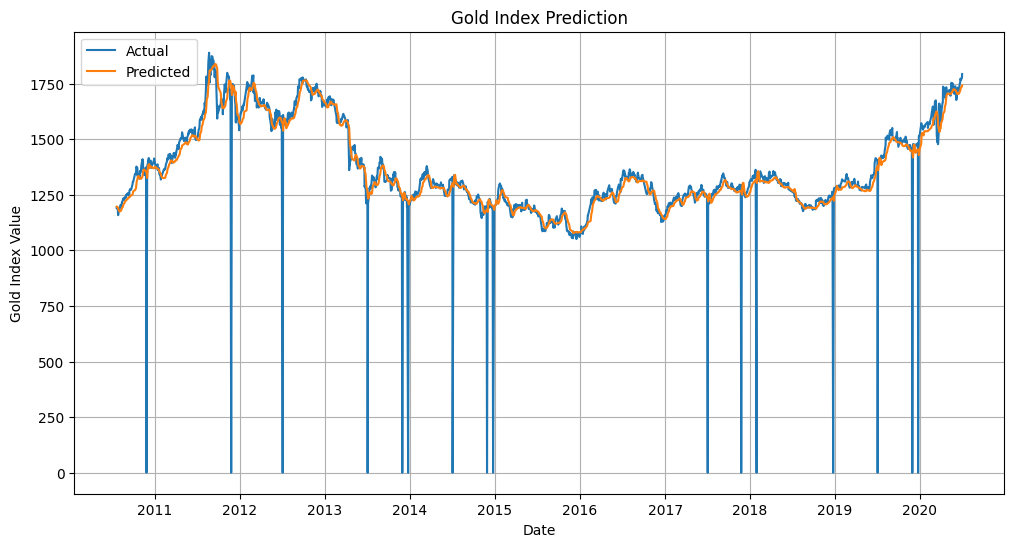

In [ ]:
# Combine the actual values and their date indices
actual_values = np.concatenate([y_train_actual, y_test_actual])
predicted_values = np.concatenate([y_train_pred, y_test_pred])
date_indices = np.concatenate([df['Date'].iloc[seq_length:train_size], df['Date'].iloc[train_size+seq_length:]])

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(date_indices, actual_values, label='Actual')
plt.plot(date_indices, predicted_values, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Gold Index Value')
plt.legend()
plt.title('Gold Index Prediction')
plt.grid(True)
plt.show()

<br><br>

## Loop the evaluation process for all the stock assets

13/13 [==============================] - 0s 5ms/step


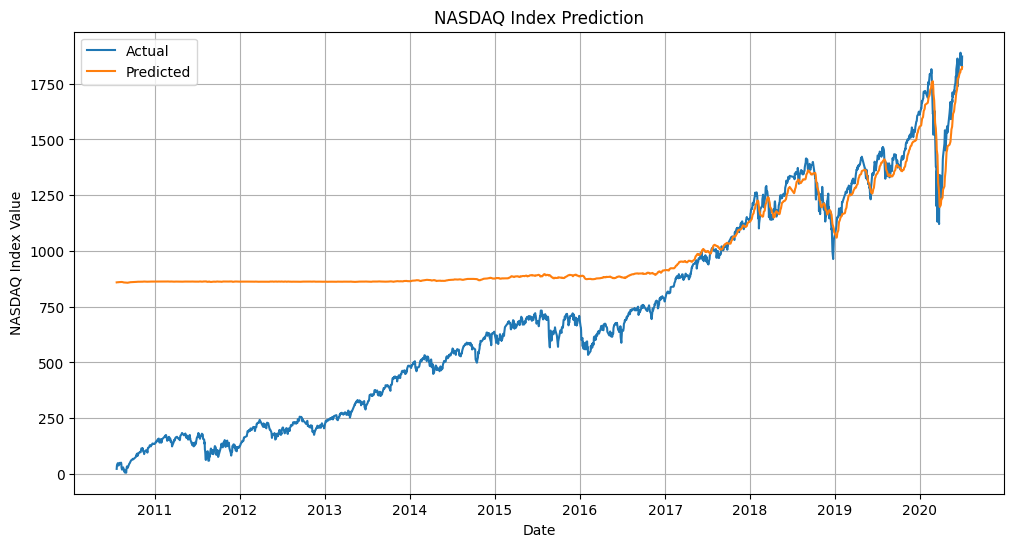


Mean Squared Error (MSE) for NASDAQ: 4953.30
Mean Absolute Error (MAE) for NASDAQ: 57.64
Root Mean Squared Error (RMSE) for NASDAQ: 70.38
R-squared (R2) for NASDAQ: 0.85




13/13 [==============================] - 0s 5ms/step


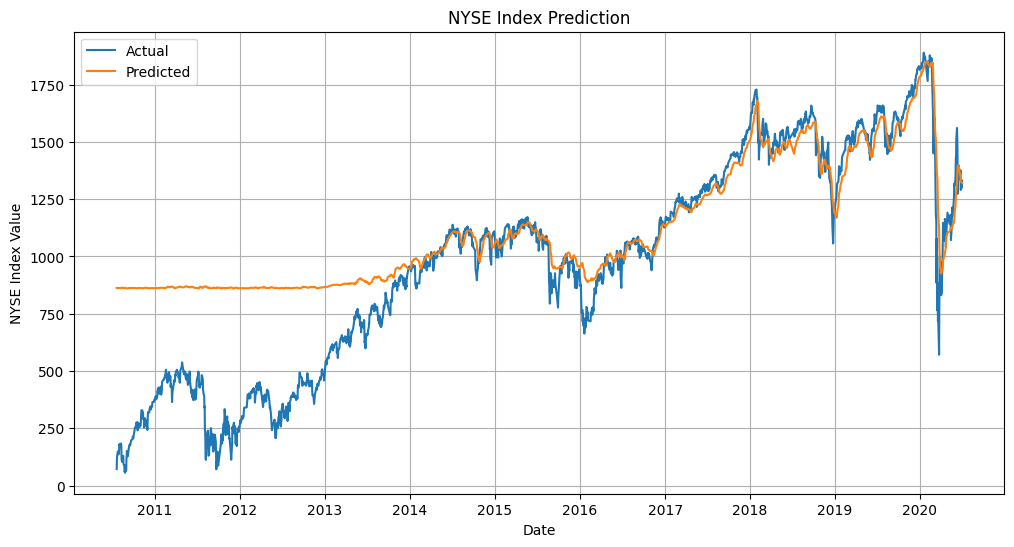


Mean Squared Error (MSE) for NYSE: 9998.28
Mean Absolute Error (MAE) for NYSE: 68.70
Root Mean Squared Error (RMSE) for NYSE: 99.99
R-squared (R2) for NYSE: 0.79




13/13 [==============================] - 0s 3ms/step


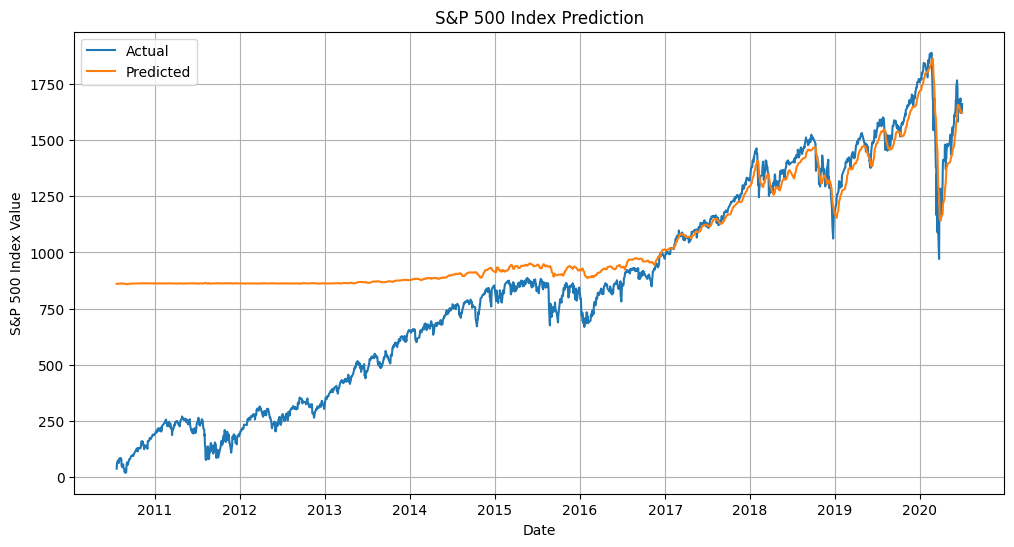


Mean Squared Error (MSE) for S&P 500: 5928.25
Mean Absolute Error (MAE) for S&P 500: 61.16
Root Mean Squared Error (RMSE) for S&P 500: 77.00
R-squared (R2) for S&P 500: 0.77




13/13 [==============================] - 0s 4ms/step


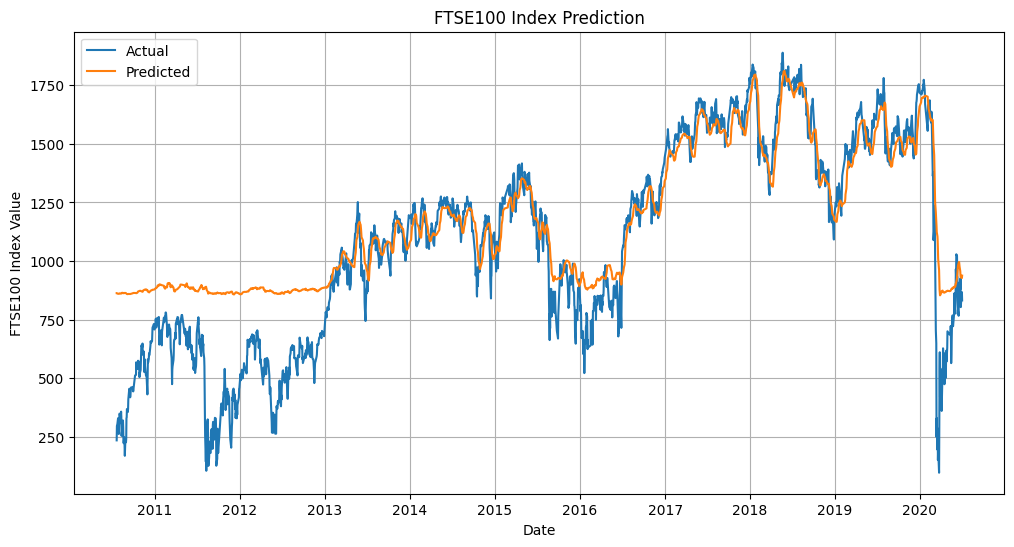


Mean Squared Error (MSE) for FTSE100: 28259.72
Mean Absolute Error (MAE) for FTSE100: 99.92
Root Mean Squared Error (RMSE) for FTSE100: 168.11
R-squared (R2) for FTSE100: 0.79




13/13 [==============================] - 0s 3ms/step


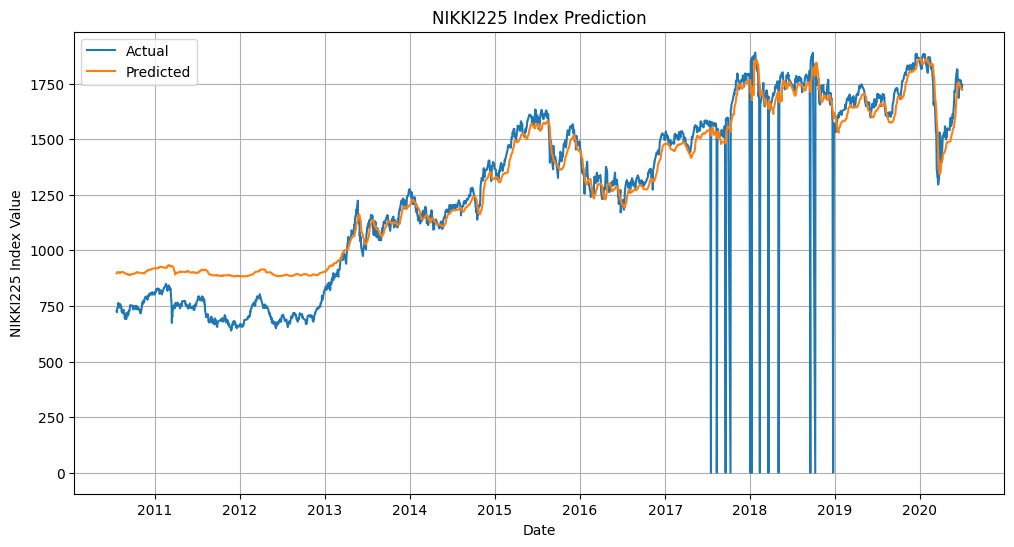


Mean Squared Error (MSE) for NIKKI225: 25602.80
Mean Absolute Error (MAE) for NIKKI225: 59.42
Root Mean Squared Error (RMSE) for NIKKI225: 160.01
R-squared (R2) for NIKKI225: 0.20




13/13 [==============================] - 0s 4ms/step


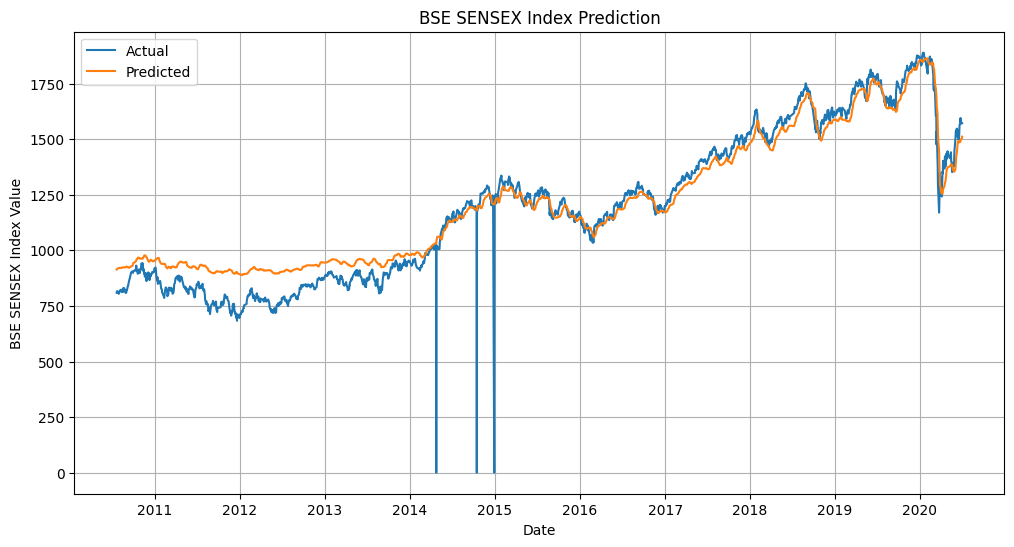


Mean Squared Error (MSE) for BSE SENSEX: 3354.71
Mean Absolute Error (MAE) for BSE SENSEX: 44.49
Root Mean Squared Error (RMSE) for BSE SENSEX: 57.92
R-squared (R2) for BSE SENSEX: 0.82




13/13 [==============================] - 0s 4ms/step


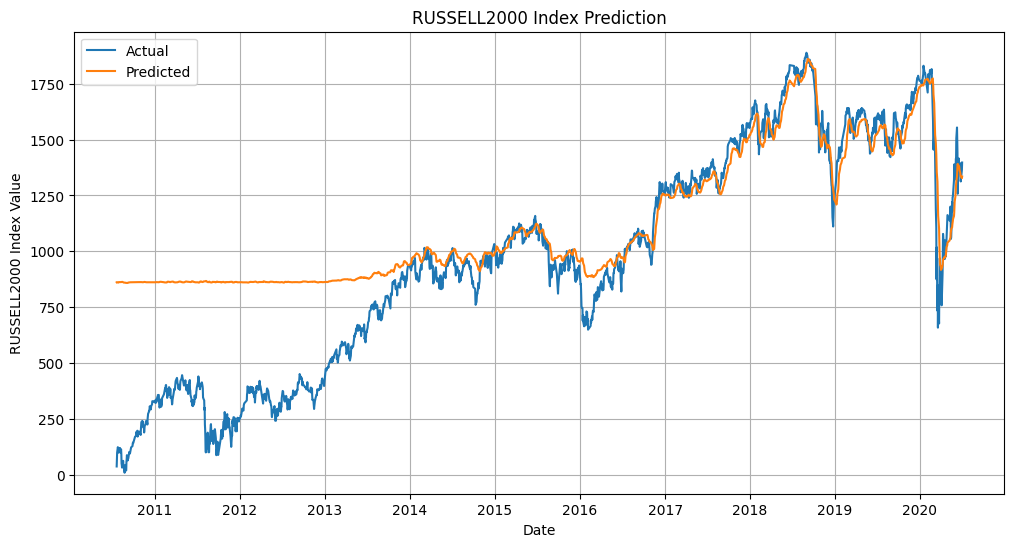


Mean Squared Error (MSE) for RUSSELL2000: 9843.74
Mean Absolute Error (MAE) for RUSSELL2000: 68.06
Root Mean Squared Error (RMSE) for RUSSELL2000: 99.22
R-squared (R2) for RUSSELL2000: 0.82




13/13 [==============================] - 0s 4ms/step


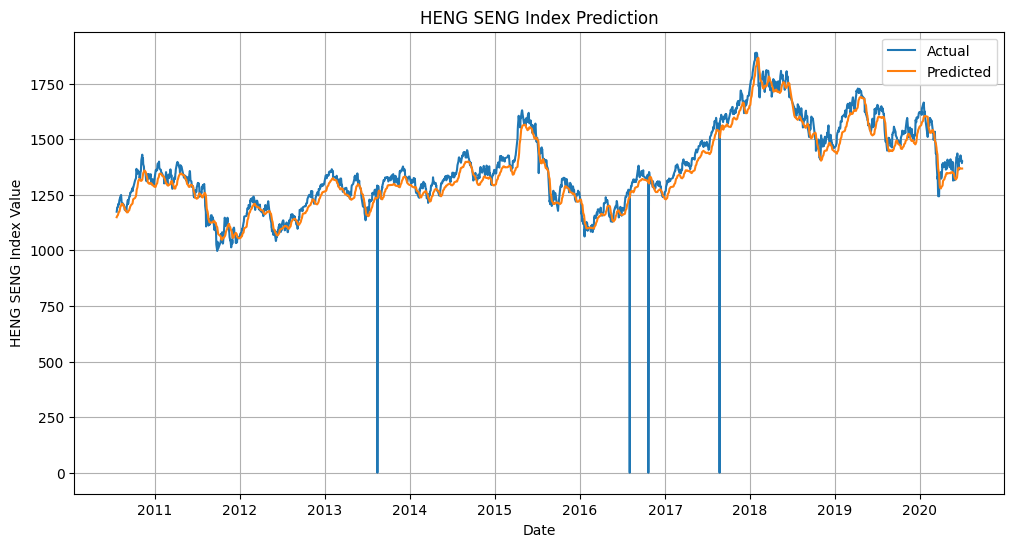


Mean Squared Error (MSE) for HENG SENG: 2611.88
Mean Absolute Error (MAE) for HENG SENG: 43.40
Root Mean Squared Error (RMSE) for HENG SENG: 51.11
R-squared (R2) for HENG SENG: 0.72




13/13 [==============================] - 0s 4ms/step


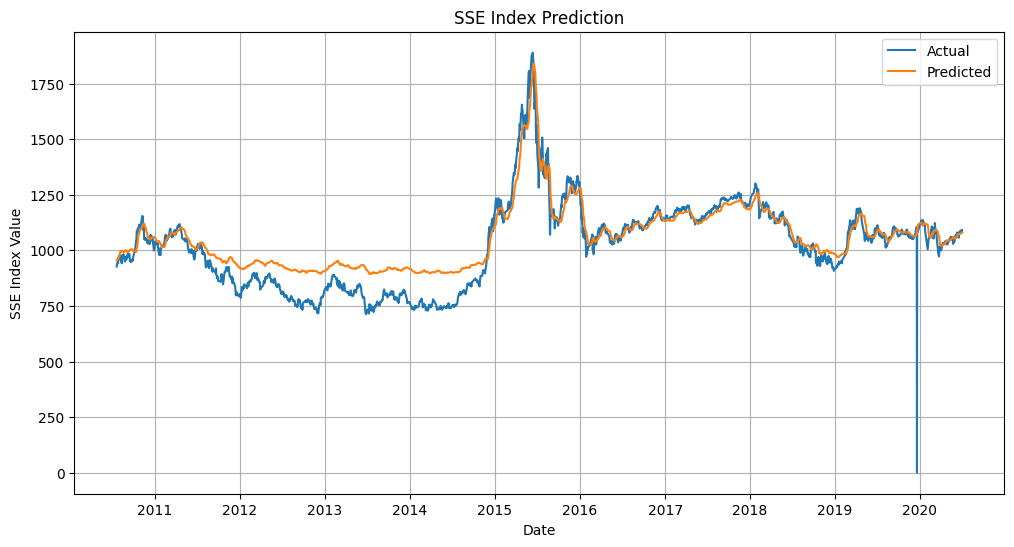


Mean Squared Error (MSE) for SSE: 3857.64
Mean Absolute Error (MAE) for SSE: 26.19
Root Mean Squared Error (RMSE) for SSE: 62.11
R-squared (R2) for SSE: 0.37




13/13 [==============================] - 0s 3ms/step


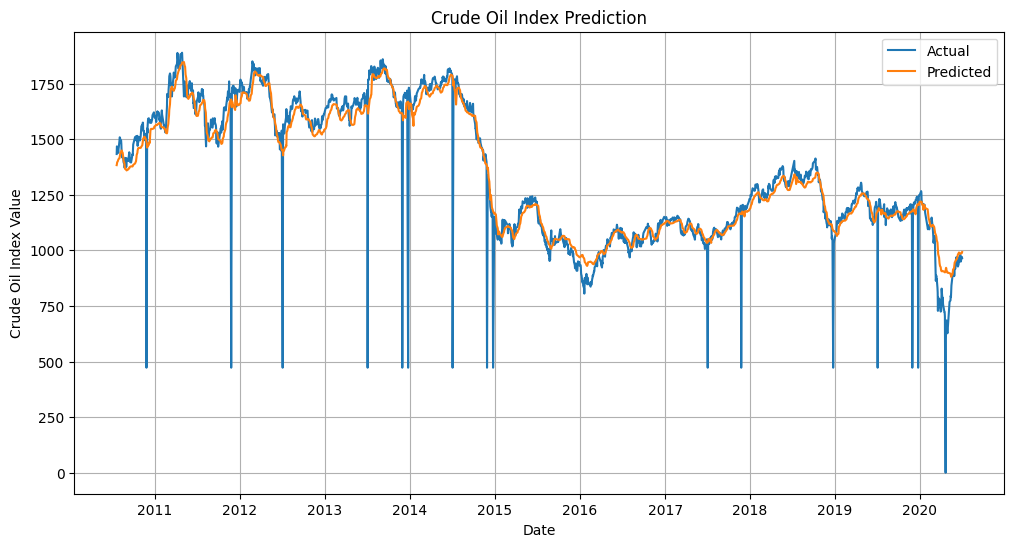


Mean Squared Error (MSE) for Crude Oil: 10839.56
Mean Absolute Error (MAE) for Crude Oil: 49.47
Root Mean Squared Error (RMSE) for Crude Oil: 104.11
R-squared (R2) for Crude Oil: 0.68




13/13 [==============================] - 0s 3ms/step


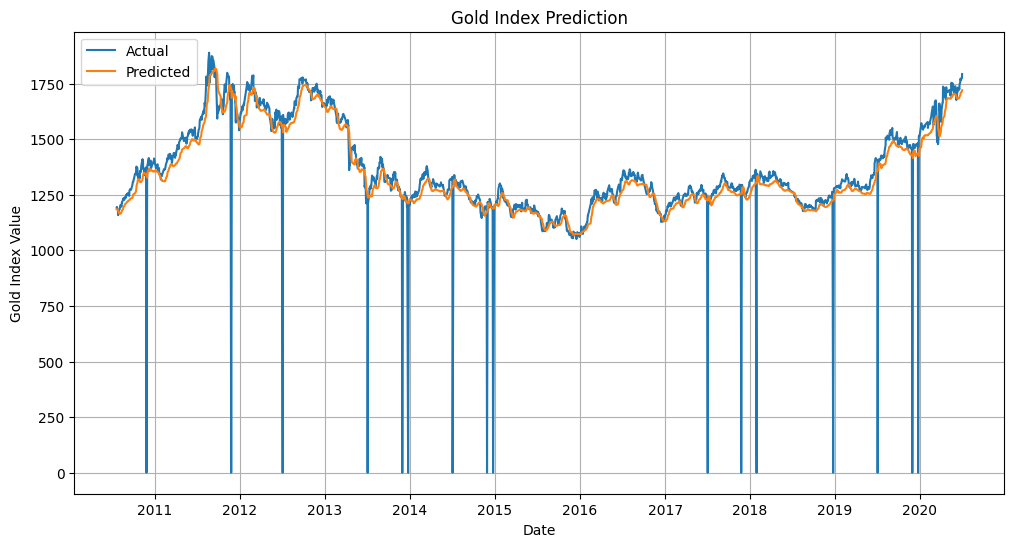


Mean Squared Error (MSE) for Gold: 20300.00
Mean Absolute Error (MAE) for Gold: 49.67
Root Mean Squared Error (RMSE) for Gold: 142.48
R-squared (R2) for Gold: 0.58




13/13 [==============================] - 0s 4ms/step


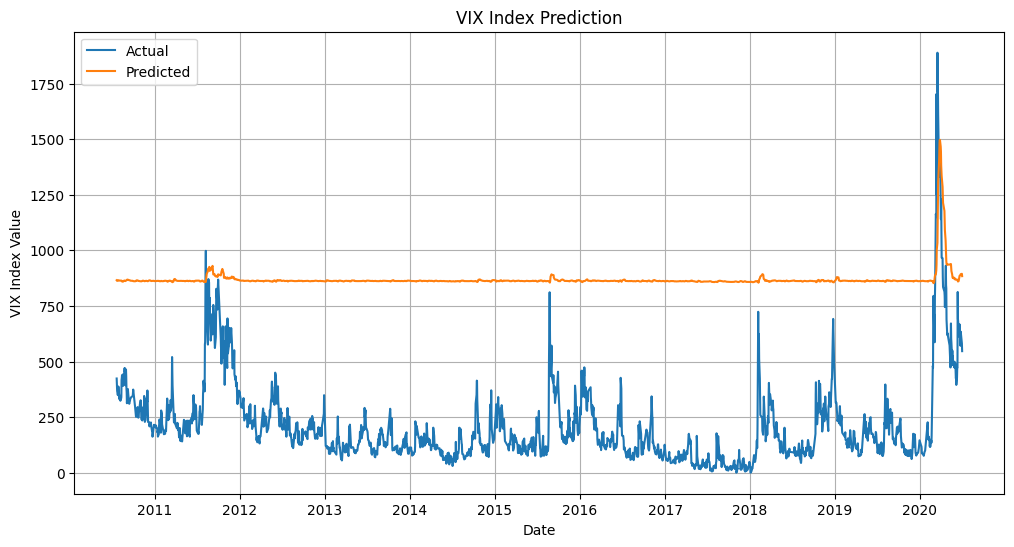


Mean Squared Error (MSE) for VIX: 419979.87
Mean Absolute Error (MAE) for VIX: 621.10
Root Mean Squared Error (RMSE) for VIX: 648.06
R-squared (R2) for VIX: -3.60




13/13 [==============================] - 0s 7ms/step


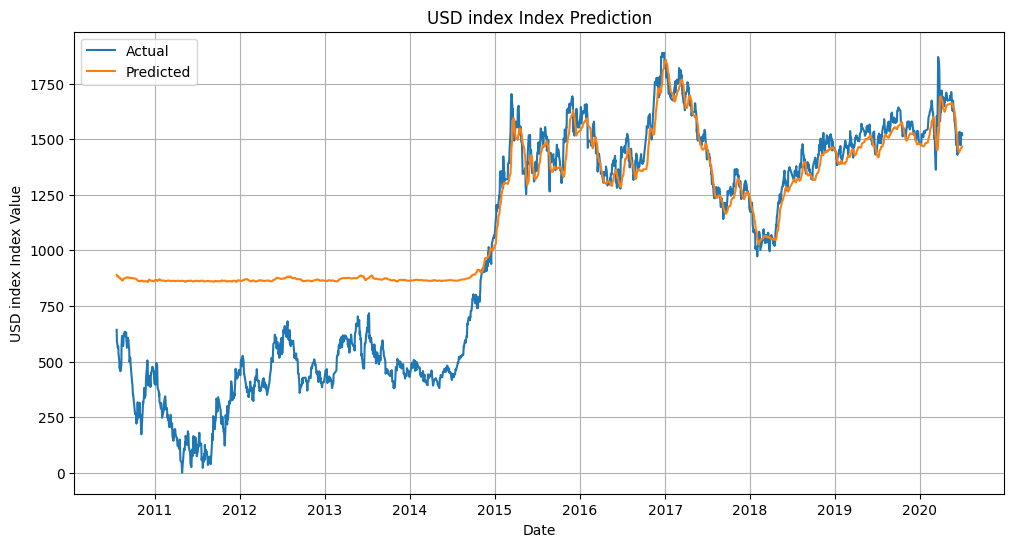


Mean Squared Error (MSE) for USD index: 3775.01
Mean Absolute Error (MAE) for USD index: 47.88
Root Mean Squared Error (RMSE) for USD index: 61.44
R-squared (R2) for USD index: 0.55




13/13 [==============================] - 0s 5ms/step


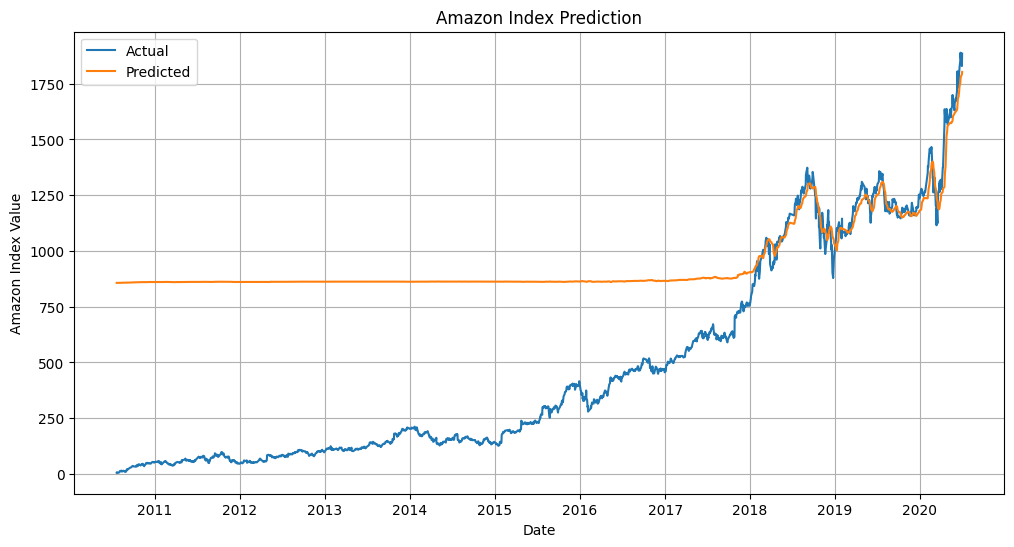


Mean Squared Error (MSE) for Amazon: 4097.43
Mean Absolute Error (MAE) for Amazon: 48.14
Root Mean Squared Error (RMSE) for Amazon: 64.01
R-squared (R2) for Amazon: 0.87




13/13 [==============================] - 0s 5ms/step


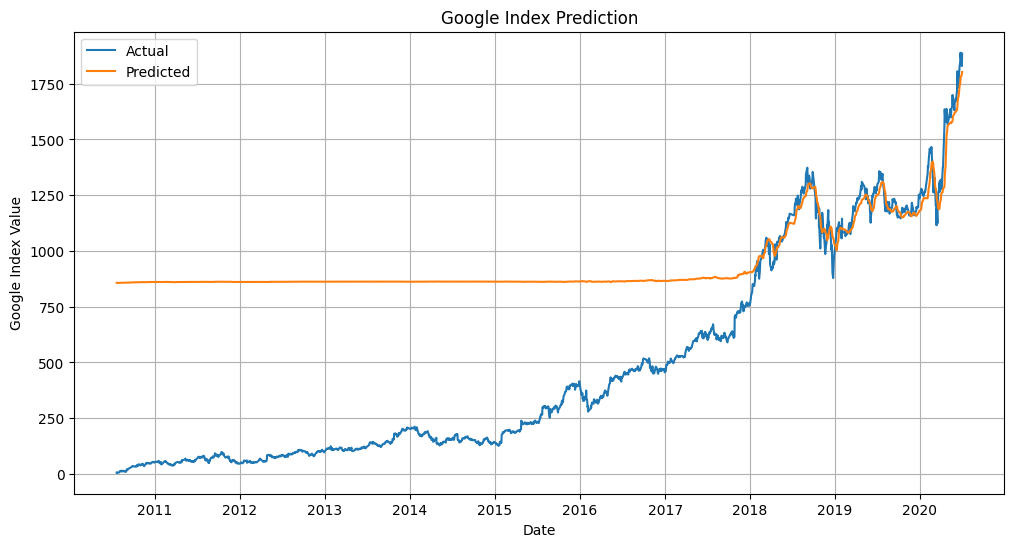


Mean Squared Error (MSE) for Google: 4097.43
Mean Absolute Error (MAE) for Google: 48.14
Root Mean Squared Error (RMSE) for Google: 64.01
R-squared (R2) for Google: 0.87




13/13 [==============================] - 0s 5ms/step


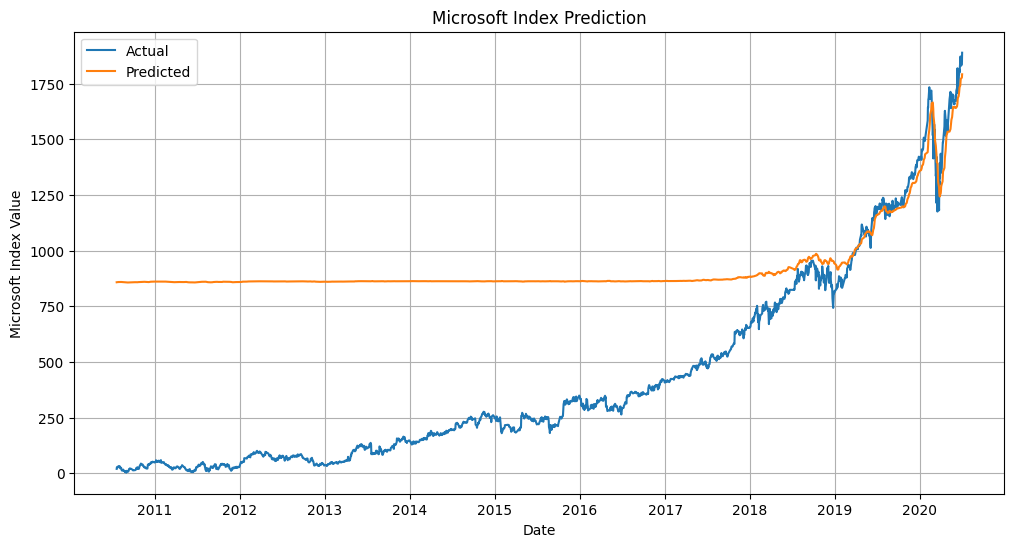


Mean Squared Error (MSE) for Microsoft: 5222.60
Mean Absolute Error (MAE) for Microsoft: 57.63
Root Mean Squared Error (RMSE) for Microsoft: 72.27
R-squared (R2) for Microsoft: 0.93






In [ ]:
assets_to_predict = ['NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']


# Create the scaler object
scaler2 = MinMaxScaler()
for asset in assets_to_predict:
    data[asset] = scaler2.fit_transform(data[[asset]])


# Function to create sequences for LSTM
def create_sequences(asset, data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[asset].iloc[i:i+seq_length]
        label = data[asset].iloc[i+seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)


def calculate_metrics(y_test_actual2, y_test_pred2):
  # Calculate the metrics
  mse2 = mean_squared_error(y_test_actual2, y_test_pred2)
  mae2 = mean_absolute_error(y_test_actual2, y_test_pred2)
  rmse2 = np.sqrt(mse2)
  r22 = r2_score(y_test_actual2, y_test_pred2)

  print(f"\nMean Squared Error (MSE) for {asset}: {mse2:.2f}")
  print(f"Mean Absolute Error (MAE) for {asset}: {mae2:.2f}")
  print(f"Root Mean Squared Error (RMSE) for {asset}: {rmse2:.2f}")
  print(f"R-squared (R2) for {asset}: {r22:.2f}")
  print("\n\n\n")


for asset in assets_to_predict:
  # Split data into training and testing sets
  train_size2 = int(len(data) * 0.80)
  test_size2 = len(data) - train_size2
  train_data2, test_data2 = data.iloc[0:train_size2], data.iloc[train_size2:len(data)]

  # Create sequences for LSTM
  seq_length = 10
  X_train2, y_train2 = create_sequences(asset, train_data2, seq_length)
  X_test2, y_test2 = create_sequences(asset, test_data2, seq_length)
  X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)
  X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

  # Make predictions
  y_train_pred2 = model.predict(X_train2)
  y_test_pred2 = model.predict(X_test2)

  # Inverse transform the scaled data to get actual values
  y_train_pred2 = scaler.inverse_transform(y_train_pred2)
  y_test_pred2 = scaler.inverse_transform(y_test_pred2)
  y_train_actual2 = scaler.inverse_transform(y_train2.reshape(-1, 1))
  y_test_actual2 = scaler.inverse_transform(y_test2.reshape(-1, 1))

  # Combine the actual values and their date indices
  actual_values2 = np.concatenate([y_train_actual2, y_test_actual2])
  predicted_values2 = np.concatenate([y_train_pred2, y_test_pred2])
  date_indices2 = np.concatenate([df['Date'].iloc[seq_length:train_size], df['Date'].iloc[train_size+seq_length:]])

  # Plot actual vs. predicted values
  plt.figure(figsize=(12, 6))
  plt.plot(date_indices2, actual_values2, label='Actual')
  plt.plot(date_indices2, predicted_values2, label='Predicted')
  plt.xlabel('Date')
  plt.ylabel(f'{asset} Index Value')
  plt.legend()
  plt.title(f'{asset} Index Prediction')
  plt.grid(True)
  plt.show()

  calculate_metrics(y_test_actual2, y_test_pred2)


